In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import os

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42

# 현재 device 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_PATH = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [5]:
DATA_PATH_model = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [6]:
df = pd.read_csv(f"{DATA_PATH}train_emotion.csv")
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,시원하고 좋은데 뾰루지 많이나고 따갑네요,1,23.09.07.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,저랑은 안맞네요 계속 쓰다보니 두피 너무 가렵고 비듬각질이 생기네요,1,23.02.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,효과는없고 계속많이빠져요,1,22.07.27.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,"제품이 어떤지는 잘 모르겠고요, 아모레퍼시픽이 소비자 생각 안 하는 회사인 건 확실...",1,22.04.05.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,ㅋㅋ최악이에요 진짜.. 3월1일에 주문했는데 3월 30일인 오늘 도착했네요 그냥 취...,1,22.03.30.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4731,머리빠짐이 덜한것 같은데 일단 더 사용해 볼게요~ 무엇보다 샴푸를 쓰고 나면 타샴푸...,5,21.11.25.,반코르,NaN,NaN,1.0,1.0,NaN,NaN,1.0
4732,확실히 기름기랑 두피여드름이 줄었어요,5,22.01.12.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4733,1. 머리 덜 간지러움 2. 각질 비듬 줄어듬 3. 머리카락이 두꺼워지는게 느껴짐 ...,5,21.12.12.,반코르,NaN,NaN,NaN,1.0,NaN,1.0,NaN
4734,지성두피라서 오후만 되면 앞머리 떡지던 사람으로서 이정도로 만족스러운 샴푸는 처음입...,5,21.12.01.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [7]:
df = df.dropna(subset='세정력/거품', axis=0).reset_index(drop=True)

In [8]:
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,세정력이 아예없어요 한번 감고 두피모공 다 막히는줄,1,22.03.29.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
1,"머리를 감았는데 감은건지 안감은건지 기름진거 같고, 몇사간지나면 떡진것 같이 보여요...",1,20.11.20.,라보에이치,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,한달 사용 리뷰 쓰기 정말 기다렸습니다. 처음 사용하고는 시원한 느낌이 있어 좋은줄...,1,20.06.24.,라보에이치,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,"좋은 후기가 많아 괜찮은 제품이라고 생각했는데, 저희 부부에겐 아니였네요. 우선 거...",1,20.06.15.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
4,제가 원래 쓰던 샴푸가 엄청 좋았던건지 이 제품이 별로인건지 전 이샴푸로 바꾸고나...,1,20.05.12.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1398,한달전에 일주일 사용후기로 먼저 후기 올렸던 사람이예요 ! 이제 한달넘게 사용하고 ...,5,21.11.11.,반코르,1.0,1.0,NaN,1.0,NaN,NaN,NaN
1399,아주 긴 머리 지성두피 사용자입니다. 머리가 길어서 머리가 잘 빠져 탈모샴푸를 쓰기...,5,21.11.20.,반코르,NaN,1.0,NaN,NaN,NaN,1.0,1.0
1400,머리카락이 너무 빠져서 서치 끝에 찾게된 반코르 확실히 빠지는게 덜합니다 머리숱은 ...,5,21.12.10.,반코르,NaN,0.0,NaN,NaN,NaN,1.0,1.0
1401,머릿결 부드러워지고 진짜 기름기가 확줄었어료,5,22.01.04.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   content      1403 non-null   object 
 1   score        1403 non-null   int64  
 2   date         1403 non-null   object 
 3   brand        1403 non-null   object 
 4   가격           242 non-null    float64
 5   세정력/거품       1403 non-null   float64
 6   향기           367 non-null    float64
 7   트러블/진정       463 non-null    float64
 8   배송/서비스/고객대응  66 non-null     float64
 9   탈모 효과 및 쿨링감  252 non-null    float64
 10  머릿결*         328 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 120.7+ KB


In [10]:
target = df.iloc[:,5].to_numpy().reshape(-1,1)
target

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]])

In [11]:
target = (target == 0).astype(int)

In [12]:
model_name = "jaehyeong/koelectra-base-v3-generalized-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [13]:
train_token = tokenizer(df['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [14]:
input_ids = np.array(train_token['input_ids'])
attention_mask = np.array(train_token['attention_mask'])
token_type_ids = np.array(train_token['token_type_ids'])

input_ids.shape, attention_mask.shape, token_type_ids.shape

((1403, 512), (1403, 512), (1403, 512))

In [15]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, token_type_ids, y_1=None, y_2=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.y_1 = y_1


    def __len__(self):
        return self.input_ids.shape[0]

    def __getitem__(self, idx):
        item = {}
        item['input_ids'] = torch.tensor(self.input_ids[idx])
        item['attention_mask'] = torch.tensor(self.attention_mask[idx])
        item['token_type_ids'] = torch.tensor(self.token_type_ids[idx])
        if self.y_1 is not None:
            item['y_1'] = torch.Tensor(self.y_1[idx])

        return item

In [16]:
class Net(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.output_layer = torch.nn.Linear( self.model.config.hidden_size , 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.model(input_ids, attention_mask, token_type_ids)
        x = self.output_layer(x[0][:,0])
        return x

In [17]:
def train_loop(dataloader, model, bce_loss_fn, optimizer, device):
    epoch_loss = 0
    model.train() # 모델 객체를 학습모드로 전환
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 이진분류 loss
        bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

        optimizer.zero_grad()
        bce_loss.backward()
        optimizer.step()

        epoch_loss += bce_loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [18]:
@torch.no_grad()
def test_loop(dataloader,model,bce_loss_fn, device):
    model.eval() # 평가 모드
    sig = torch.nn.Sigmoid()
    pred_1_list = []

    epoch_loss = 0
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 검증 평가할 경우
        if batch.get("y_1") is not None:
            bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

            epoch_loss += bce_loss.item()

        # 예측값 만들기
        pred_1 = sig(pred).to("cpu").numpy()

        pred_1_list.append(pred_1)

    pred_1 = np.concatenate(pred_1_list)
    epoch_loss /= len(dataloader)
    return epoch_loss, pred_1

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score

batch_size = 4
bce_loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 100
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)

In [20]:
is_holdout = False
reset_seeds(SEED)
best_score_list = []
best_recall_score_list = []
best_precision_score_list = []

for i, (tri, vai) in enumerate(cv.split(input_ids, target)):
    model = Net(model_name).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # 학습용
    train_dt = ReviewDataset(input_ids[tri], attention_mask[tri], token_type_ids[tri], target[tri])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용
    valid_dt = ReviewDataset(input_ids[vai], attention_mask[vai], token_type_ids[vai], target[vai])
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    best_score = 0
    best_recall_score = 0
    best_precision_score = 0


    patience = 0
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, bce_loss_fn, optimizer, device)
        valid_loss, pred= test_loop(valid_dl, model, bce_loss_fn, device)

        # multi-label Classification
        pred = (pred > 0.5).astype(int)
        f1 = f1_score(target[vai], pred)
        recall = recall_score(target[vai], pred)
        precision = precision_score(target[vai], pred)
        patience += 1

        if best_score < f1:
            patience = 0
            best_score = f1
            best_recall_score = recall
            best_precision_score = precision
            torch.save(model.state_dict(), f"{DATA_PATH_model}model_emotion_bubble_{i}.pth")

        print("f1_score_1:", f1)
        print("recall:", recall)
        print("precision:", precision)
        print("train_loss:", train_loss)
        print("valid_loss:", valid_loss)
        if patience == 5:
            break

    print(f"{i} 번째 폴드 best f1_score_1: {best_score}")
    print(f"{i} 번째 폴드 best recall_score: {best_recall_score}")
    print(f"{i} 번째 폴드 best precision_score: {best_precision_score}")
    best_score_list.append(best_score)
    best_recall_score_list.append(best_recall_score)
    best_precision_score_list.append(best_precision_score)
    if is_holdout:
        break

print(np.mean(best_score_list))
print(np.mean(best_recall_score_list))
print(np.mean(best_precision_score_list))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8292682926829269
recall: 0.7391304347826086
precision: 0.9444444444444444
train_loss: 0.27357996224004816
valid_loss: 0.15601997334562556


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8695652173913043
recall: 0.8695652173913043
precision: 0.8695652173913043
train_loss: 0.10099737894360068
valid_loss: 0.1327135544926138


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.23076923076923078
recall: 0.13043478260869565
precision: 1.0
train_loss: 0.08389702913089526
valid_loss: 0.4332164194185654


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.0
recall: 0.0
precision: 0.0
train_loss: 0.45077419973034877
valid_loss: 0.4432481665846328


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.0
recall: 0.0
precision: 0.0
train_loss: 0.4473347268813021
valid_loss: 0.44460280743283287


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.0
recall: 0.0
precision: 0.0
train_loss: 0.4507815921645996
valid_loss: 0.44310438150251413


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1_score_1: 0.0
recall: 0.0
precision: 0.0
train_loss: 0.4484814684374052
valid_loss: 0.4438317439086001
0 번째 폴드 best f1_score_1: 0.8695652173913043
0 번째 폴드 best recall_score: 0.8695652173913043
0 번째 폴드 best precision_score: 0.8695652173913043


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8095238095238095
recall: 0.7391304347826086
precision: 0.8947368421052632
train_loss: 0.24424540965396951
valid_loss: 0.14077531302374013


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.909090909090909
recall: 0.8695652173913043
precision: 0.9523809523809523
train_loss: 0.09669957145571284
valid_loss: 0.10154683289813324


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.9213483146067417
recall: 0.8913043478260869
precision: 0.9534883720930233
train_loss: 0.03460624269491519
valid_loss: 0.09068639185541952


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.9130434782608695
recall: 0.9130434782608695
precision: 0.9130434782608695
train_loss: 0.017530103526459312
valid_loss: 0.0951831092808763


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.9213483146067417
recall: 0.8913043478260869
precision: 0.9534883720930233
train_loss: 0.022000228794742362
valid_loss: 0.11538483913738648


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.9010989010989011
recall: 0.8913043478260869
precision: 0.9111111111111111
train_loss: 0.01403920694993431
valid_loss: 0.13078511822444033


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.9010989010989011
recall: 0.8913043478260869
precision: 0.9111111111111111
train_loss: 0.0034352276727782557
valid_loss: 0.13163893123347523


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.888888888888889
recall: 0.8695652173913043
precision: 0.9090909090909091
train_loss: 0.003098050620426752
valid_loss: 0.14493673246084962
1 번째 폴드 best f1_score_1: 0.9213483146067417
1 번째 폴드 best recall_score: 0.8913043478260869
1 번째 폴드 best precision_score: 0.9534883720930233


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8113207547169811
recall: 0.9347826086956522
precision: 0.7166666666666667
train_loss: 0.23434868299823214
valid_loss: 0.19160784551427817


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8275862068965518
recall: 0.782608695652174
precision: 0.8780487804878049
train_loss: 0.07748475576356531
valid_loss: 0.18525236006826162


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.782608695652174
recall: 0.782608695652174
precision: 0.782608695652174
train_loss: 0.035290819191741776
valid_loss: 0.30310686356322447


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.7789473684210526
recall: 0.8043478260869565
precision: 0.7551020408163265
train_loss: 0.017010562743302236
valid_loss: 0.3477554625641345


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.7954545454545455
recall: 0.7608695652173914
precision: 0.8333333333333334
train_loss: 0.015984265303597173
valid_loss: 0.326226455047989


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8666666666666666
recall: 0.8478260869565217
precision: 0.8863636363636364
train_loss: 0.024068233931563078
valid_loss: 0.16662119152221147


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8349514563106796
recall: 0.9347826086956522
precision: 0.7543859649122807
train_loss: 0.020545142159210616
valid_loss: 0.21954271338001208


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8421052631578948
recall: 0.8695652173913043
precision: 0.8163265306122449
train_loss: 0.004998275846097075
valid_loss: 0.26093936471012746


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8478260869565218
recall: 0.8478260869565217
precision: 0.8478260869565217
train_loss: 0.0030424235313235917
valid_loss: 0.2802815524808748


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8125
recall: 0.8478260869565217
precision: 0.78
train_loss: 0.0026055642335718744
valid_loss: 0.3106359590917275


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

f1_score_1: 0.8210526315789473
recall: 0.8478260869565217
precision: 0.7959183673469388
train_loss: 0.001990181823953774
valid_loss: 0.31883158795551964
2 번째 폴드 best f1_score_1: 0.8666666666666666
2 번째 폴드 best recall_score: 0.8478260869565217
2 번째 폴드 best precision_score: 0.8863636363636364


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.8333333333333333
recall: 0.8695652173913043
precision: 0.8
train_loss: 0.24472892943942037
valid_loss: 0.13808606561007244


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.8842105263157894
recall: 0.9130434782608695
precision: 0.8571428571428571
train_loss: 0.08898228295213706
valid_loss: 0.12964176726527513


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.8478260869565218
recall: 0.8478260869565217
precision: 0.8478260869565217
train_loss: 0.053845544708594414
valid_loss: 0.12634779576079122


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.8484848484848485
recall: 0.9130434782608695
precision: 0.7924528301886793
train_loss: 0.02784787458483647
valid_loss: 0.17611129811432744


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.8444444444444444
recall: 0.8260869565217391
precision: 0.8636363636363636
train_loss: 0.026628312917452743
valid_loss: 0.1955773649238316


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.8444444444444444
recall: 0.8260869565217391
precision: 0.8636363636363636
train_loss: 0.029476575560045837
valid_loss: 0.22378131093490602


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.8222222222222223
recall: 0.8043478260869565
precision: 0.8409090909090909
train_loss: 0.013254036765638407
valid_loss: 0.1760523834997522
3 번째 폴드 best f1_score_1: 0.8842105263157894
3 번째 폴드 best recall_score: 0.9130434782608695
3 번째 폴드 best precision_score: 0.8571428571428571


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.8863636363636365
recall: 0.8478260869565217
precision: 0.9285714285714286
train_loss: 0.2664382997568816
valid_loss: 0.1285659255992089


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.8809523809523809
recall: 0.8043478260869565
precision: 0.9736842105263158
train_loss: 0.10174086554062112
valid_loss: 0.12986749182455243


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.8965517241379309
recall: 0.8478260869565217
precision: 0.9512195121951219
train_loss: 0.057808199329003426
valid_loss: 0.10161838166947876


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.9195402298850575
recall: 0.8695652173913043
precision: 0.975609756097561
train_loss: 0.028509622283969274
valid_loss: 0.099732070283166


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.0
recall: 0.0
precision: 0.0
train_loss: 0.08694072733997794
valid_loss: 0.43508074171841143


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.0
recall: 0.0
precision: 0.0
train_loss: 0.44273940837043885
valid_loss: 0.44669536245720726


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.0
recall: 0.0
precision: 0.0
train_loss: 0.4467950197619476
valid_loss: 0.4506922534533909


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.0
recall: 0.0
precision: 0.0
train_loss: 0.4460384851301692
valid_loss: 0.4472294841493879


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

f1_score_1: 0.0
recall: 0.0
precision: 0.0
train_loss: 0.4495223987038874
valid_loss: 0.44715574617896764
4 번째 폴드 best f1_score_1: 0.9195402298850575
4 번째 폴드 best recall_score: 0.8695652173913043
4 번째 폴드 best precision_score: 0.975609756097561
0.8922661909731119
0.8782608695652174
0.9084339678176765


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
DATA_PATH_test = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [22]:
test = pd.read_csv(f"{DATA_PATH_test}test_emotion.csv")
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,배송누락되어 본사확신다고 하시고 다시 주문번호 올려달라고 하시니 대응절차가 문제있어...,1,23.08.31.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,전에 쓰던 샴푸보다 머리카락 더빠짐…,1,23.03.25.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,사용감은 더 느껴봐야겠지만 1회 사용해보니 젤 고민스러운 정수리엔 효과적이지 않네요...,1,21.06.13.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,머리카락 끝이 엉키고 ㅠ비듬그대로 ㅡㅡ그냥 아까워서 쓰고 있어요 ....두피 여드름...,1,20.12.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,0.0
4,세정력은 낮고 일단 두피가 따갑고 피부트러블이 생깁니다,1,20.12.26.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1179,머릿결이 부드러워요,5,22.01.27.,반코르,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1180,출산후 머리가 엄청 빠진다고 해서 임신했을때부터 썼습니다 제가 쓰려고 산 건데 남편...,5,21.12.17.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1181,출산한지 3개월에 단유하고 나니 호르몬이 돌아오면서 임신전 두피에 지루피부염이 다시...,5,21.12.08.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1182,머릿결이 좀 좋아졌어요 거품도 잘 나서 만족해요,5,21.12.12.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [23]:
test = test.dropna(subset='세정력/거품', axis=0).reset_index(drop=True)

In [24]:
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,세정력은 낮고 일단 두피가 따갑고 피부트러블이 생깁니다,1,20.12.26.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
1,일단 머리 냄새를 잘 못잡고 머리가 안빠지는지도 잘모르겠요,2,22.08.18.,라보에이치,NaN,0.0,NaN,NaN,NaN,0.0,NaN
2,사실 큰 효과는 모르겠어요ㅠ 거품이 잘 나고 시원한 느낌이 나긴 하는데 한달이라 잘...,2,20.09.30.,라보에이치,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,음 크림샴푸라 그런가 헹궈지는게 잘 모르겠고 머리가 기름지는 기분입니다 뭔가 뭉턱이...,2,20.07.03.,라보에이치,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,저는 이 샴푸 쓰고 두피각질이 더 일어났어요.(샴푸쓰기전보다) 샴푸할 때는 화한 느...,2,20.05.29.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
346,저는 한달간 사용해본 결과 사진처럼 탈모예방의 효과는 거의 없었습니다. 간혹 두 ...,5,21.11.25.,반코르,NaN,1.0,NaN,1.0,NaN,0.0,NaN
347,3일째 사용중인데 두피 가려운거 없고 기름도 확실히 덜져요. 머릿결이 부드러운 느낌...,5,21.12.30.,반코르,NaN,1.0,NaN,1.0,NaN,NaN,NaN
348,거품이 풍성하게 잘 나요. 향도 맘에 들고요. 환절기에 비듬케어하는 샴푸를 썼더니 ...,5,21.12.22.,반코르,NaN,1.0,1.0,NaN,NaN,1.0,NaN
349,머릿결이 좀 좋아졌어요 거품도 잘 나서 만족해요,5,21.12.12.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [25]:
test_target = test.iloc[:,5].to_numpy().reshape(-1,1)
test_target

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [26]:
test_target = (test_target == 0).astype(int)

In [27]:
test_token = tokenizer(test['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [28]:
test_input_ids = np.array(test_token['input_ids'])
test_attention_mask = np.array(test_token['attention_mask'])
test_token_type_ids = np.array(test_token['token_type_ids'])

test_input_ids.shape, test_attention_mask.shape, test_token_type_ids.shape

((351, 512), (351, 512), (351, 512))

In [29]:
batch_size = 4

In [30]:
test_dt = ReviewDataset(test_input_ids, test_attention_mask, test_token_type_ids)
test_dl = torch.utils.data.DataLoader(test_dt, batch_size=batch_size, shuffle = False)

pred_list = []
for i in range(n_splits):
    model = Net(model_name).to(device)
    state_dict = torch.load(f"{DATA_PATH_model}model_emotion_bubble_{i}.pth") # 가중치 불러오기
    model.load_state_dict(state_dict) # 모델에 가중치 세팅

    _, pred = test_loop(test_dl, model, bce_loss_fn, device)
    pred_list.append(pred)

pred = np.mean(pred_list, axis=0)

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

In [31]:
pred = (pred > 0.5).astype(int)

In [32]:
f1_score(test_target, pred)

0.9142857142857143

In [33]:
recall_score(test_target, pred)

0.8421052631578947

In [34]:
precision_score(test_target, pred)

1.0

In [36]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(test_target, pred)
cm2

array([[294,   0],
       [  9,  48]])

In [38]:
import seaborn as sns

cmdf2 = pd.DataFrame(cm2, index=['실제값(N)', '실제값(P)'], columns=['예측값(N)', '예측값(P)'])
cmdf2

,예측값(N),예측값(P)
실제값(N),294,0
실제값(P),9,48


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(test_target, pred)
# 정규화를 위해 각 행의 합으로 나누기
normalized_cm = np.zeros_like(cm, dtype=np.float32)
for i in range(cm.shape[0]):
    row_sum = cm[i].sum()
    if row_sum != 0:
        normalized_cm[i] = cm[i] / row_sum

normalized_cm

array([[1.        , 0.        ],
       [0.15789473, 0.84210527]], dtype=float32)

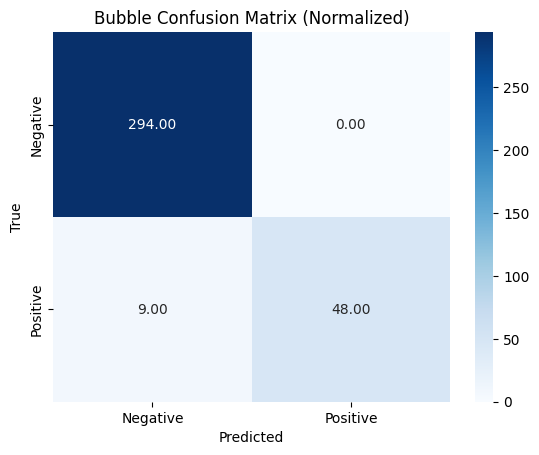

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_target, pred)
normalized_cm
labels = ['Negative', 'Positive']  # 이진 분류 레이블
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
# title 에서 앞부분 본인 주제에 맞는 걸로 바꿔주세요.
plt.title('Bubble Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()